In [4]:
#구글드라이브 mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. 클라우드 이미지 압축 해제

In [11]:
!pwd
%cd drive/MyDrive/Colab Notebooks/Data-Science/data/
!ls

/content
/content/drive/MyDrive/Colab Notebooks/Data-Science/data
img  rock_scissor_paper


In [ ]:
%cd rock_scissor_paper/

/content/drive/My Drive/Colab Notebooks/Data-Science/data/rock_scissor_paper


In [ ]:
%cd rock
!unzip rock.zip

In [ ]:
%cd ../scissor/
!unzip scissor.zip

In [ ]:
%cd ../paper/
!unzip paper.zip

### 2. 데이터 불러오기 + Resize 하기

In [12]:
from PIL import Image
import os, glob


In [ ]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

  # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/scissor'
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/rock'
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/paper'
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

993  images to be resized.


### 3. 이미지 라벨링(가위: 0, 바위: 1, 보: 2)

In [9]:
import numpy as np

def load_data(img_path, number_of_data=3206):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper'
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

KeyboardInterrupt: ignored

In [10]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print(y_train[0])

NameError: ignored

### 4. 딥러닝 네트워크 설계하기

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

channel_1 = 32
channel_2 = 64
dense = 64
train_epoch = 10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
#model.add(keras.layers.MaxPooling2D((2,2)))

# overfitting.....
#model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (No

### 5. Train

#### train set, test set 나누기

In [ ]:
from sklearn.model_selection import train_test_split
x_train_split, x_test, y_train_split, y_test = train_test_split(x_train, y_train, test_size=0.3)

x_train_split_norm = x_train/255.0  # normalize to 0~1
x_test_norm = x_test/255.0   

print(x_train_split.shape)
print(x_test.shape)
print(y_train_split.shape)
print(y_test.shape)

(2244, 28, 28, 3)
(963, 28, 28, 3)
(2244,)
(963,)


0


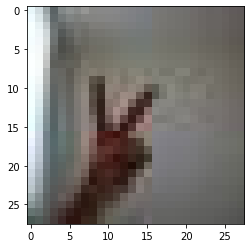

In [ ]:
idx = 1
plt.imshow(x_test[idx])
print(y_test[idx])

### train model

In [ ]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
# [[YOUR CODE]]

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10)

Epoch 1/10
71/71 [==============================] - 3s 30ms/step - loss: 4.9597 - accuracy: 0.4514
Epoch 2/10
71/71 [==============================] - 2s 31ms/step - loss: 0.7737 - accuracy: 0.6364
Epoch 3/10
71/71 [==============================] - 2s 31ms/step - loss: 0.6028 - accuracy: 0.7482
Epoch 4/10
71/71 [==============================] - 2s 31ms/step - loss: 0.4698 - accuracy: 0.8097
Epoch 5/10
71/71 [==============================] - 2s 31ms/step - loss: 0.3307 - accuracy: 0.8806
Epoch 6/10
71/71 [==============================] - 2s 31ms/step - loss: 0.2595 - accuracy: 0.8997
Epoch 7/10
71/71 [==============================] - 2s 30ms/step - loss: 0.2621 - accuracy: 0.9015
Epoch 8/10
71/71 [==============================] - 2s 31ms/step - loss: 0.1846 - accuracy: 0.9278
Epoch 9/10
71/71 [==============================] - 2s 31ms/step - loss: 0.1481 - accuracy: 0.9461
Epoch 10/10
71/71 [==============================] - 2s 31ms/step - loss: 0.1504 - accuracy: 0.9470


1


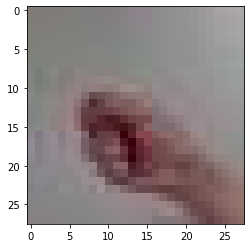

In [ ]:
idx = 10
plt.imshow(x_test[idx])
print(y_test[idx])

### test accuracy 측정

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

31/31 - 0s - loss: 0.2142 - accuracy: 0.9200
test_loss: 0.21417735517024994 
test_accuracy: 0.920041561126709


### ※ 새로운 data set으로 test할 경우   
- hyper parameter를 수정하고, train dataset을 `Dropout`시켜 `overfitting`을 막고자 함  
=> `accuracy` : 57%. 3번 루브릭을 충족하지 못함 ..

### 이미지 데이터

In [ ]:
!pwd
%cd ../test/rock/
!unzip rock.zip

In [ ]:
%cd ../scissor/
!unzip scissor.zip

In [ ]:
%cd ../paper/
!unzip paper.zip

In [ ]:
# test img resize(28*28)
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/scissor'
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/rock'
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/paper'
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
70  images to be resized.
70  images resized.
바위 이미지 resize 완료!
104  images to be resized.
104  images resized.
보 이미지 resize 완료!


In [ ]:
# 0,1,2 라벨링
image_dir_path = '/content/drive/MyDrive/Colab Notebooks/Data-Science/data/rock_scissor_paper/test/'
(x_test_new, y_test_new)=load_data(image_dir_path, 274)
x_test_new_norm = x_test_new/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test_new shape: {}".format(x_test_new.shape))
print("y_test_new: {}".format(y_test_new.shape))

학습데이터(x_train)의 이미지 개수는 274 입니다.
x_test_new shape: (274, 28, 28, 3)
y_test_new: (274,)


#### 딥러닝 네트워크 설계

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

channel_1 = 32
channel_2 = 64
dense = 64
train_epoch = 18

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

# overfitting.....
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  10
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          

#### 모델 train

In [ ]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
# [[YOUR CODE]]

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20)

Epoch 1/20
71/71 [==============================] - 3s 34ms/step - loss: 1.8122 - accuracy: 0.4474
Epoch 2/20
71/71 [==============================] - 2s 34ms/step - loss: 0.7376 - accuracy: 0.6573
Epoch 3/20
71/71 [==============================] - 2s 34ms/step - loss: 0.5376 - accuracy: 0.7611
Epoch 4/20
71/71 [==============================] - 2s 33ms/step - loss: 0.5417 - accuracy: 0.7727
Epoch 5/20
71/71 [==============================] - 2s 34ms/step - loss: 0.3189 - accuracy: 0.8717
Epoch 6/20
71/71 [==============================] - 2s 33ms/step - loss: 0.2615 - accuracy: 0.8988
Epoch 7/20
71/71 [==============================] - 2s 33ms/step - loss: 0.2538 - accuracy: 0.8975
Epoch 8/20
71/71 [==============================] - 2s 33ms/step - loss: 0.1680 - accuracy: 0.9381
Epoch 9/20
71/71 [==============================] - 2s 34ms/step - loss: 0.1491 - accuracy: 0.9381
Epoch 10/20
71/71 [==============================] - 2s 33ms/step - loss: 0.1570 - accuracy: 0.9389
Epoch 11/

### Test

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_new,y_test_new, verbose=2)
print("test_loss_new: {} ".format(test_loss))
print("test_accuracy_new: {}".format(test_accuracy))

9/9 - 0s - loss: 2.5784 - accuracy: 0.4818
test_loss_new: 2.578352451324463 
test_accuracy_new: 0.48175182938575745
